In [1]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        input_projection = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
            input_projection.append(self.input2h(input[i]))

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        input_projection = torch.stack(input_projection, dim=0)  
        
        return output, hidden, input_projection


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, hidden, input_projection = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output, input_projection
    
    
    

/Users/jacobtanner/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/jacobtanner/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


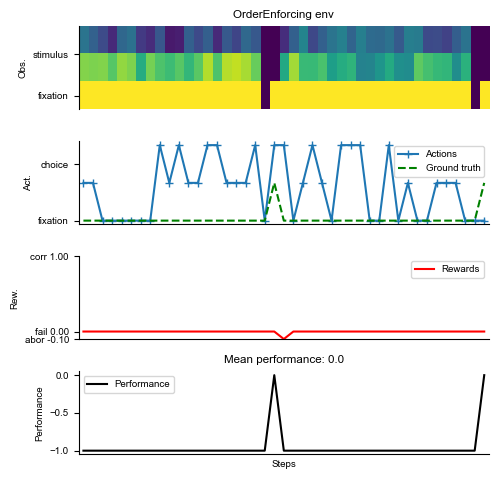

In [2]:

import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n



In [13]:


import torch.optim as optim

# Instantiate the network and print information
hidden_size = 100
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i in range(1000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, _,_ = net(inputs)
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0
        
        

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=100, bias=True)
    (h2h): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
Step 100, Loss 0.0740
Step 200, Loss 0.0197
Step 300, Loss 0.0155
Step 400, Loss 0.0136
Step 500, Loss 0.0118
Step 600, Loss 0.0127
Step 700, Loss 0.0129
Step 800, Loss 0.0120
Step 900, Loss 0.0119
Step 1000, Loss 0.0126


In [14]:


import scipy.io as sio

import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
all_inputs = []
all_outputs = []
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity,_ = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = gt
    all_inputs.append(inputs.detach().numpy())
    all_outputs.append(action_pred.detach().numpy())
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)


mdic = {"activity": activity}

sio.savemat("data/activity_pdm.mat", mdic)

mdic = {"all_inputs": all_inputs}

sio.savemat("data/all_inputs_pdm.mat", mdic)
    
    
mdic = {"all_outputs": all_outputs}

sio.savemat("data/all_outputs.mat", mdic)


IW = net.rnn.input2h.weight.detach().numpy()

mdic = {"IW": IW}

sio.savemat("data/IW.mat", mdic)



Shape of the neural activity: (Time points, Neurons):  (2200, 100)


In [72]:



# Save entire model
torch.save(net, 'good_RNN_perc_dm.pth')


In [6]:


net = torch.load('good_RNN_perc_dm.pth')



Shape of the neural activity: (Time points, Neurons):  (2200, 100)
Trial  0 {'ground_truth': 0, 'coh': 0.0}
Trial  1 {'ground_truth': 0, 'coh': 12.8}
Trial  2 {'ground_truth': 0, 'coh': 51.2}
Trial  3 {'ground_truth': 1, 'coh': 51.2}
Trial  4 {'ground_truth': 1, 'coh': 51.2}


Text(0, 0.5, 'PC 2')

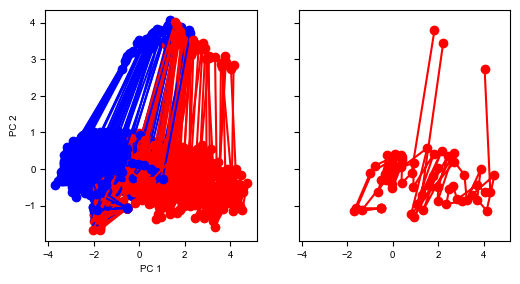

In [25]:

import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity,_ = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial
    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

# Print trial informations
for i in range(5):
    print('Trial ', i, trial_infos[i])
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')





(100, 16)


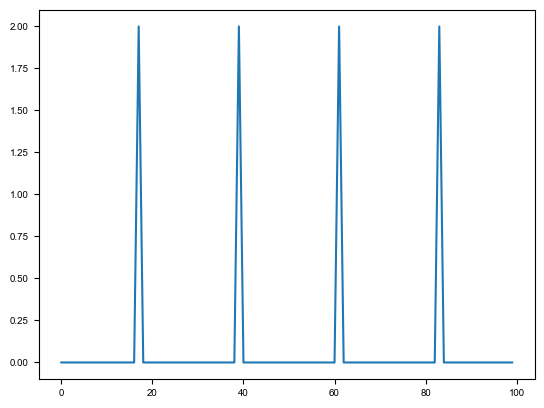

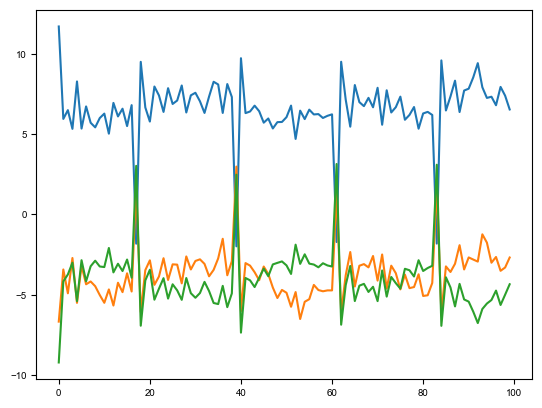

In [43]:
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)
#labels = torch.from_numpy(labels.flatten()).type(torch.long)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output, _,_ = net(inputs)


o = output[:,0].detach().numpy()
l = labels[:,0]

print(labels.shape)


plt.plot(l)
plt.show()
plt.plot(o)
plt.show()

In [2]:
import scipy.io
import copy

# Load the .mat file
mat_data = scipy.io.loadmat('data\modules.mat')

# mat_data is a dictionary with variable names as keys and loaded matrices as values
modules = mat_data['modules']


def lesion_rnn_out(model, neuron_index):
    """
    Lesion an RNN model at the given neuron index.

    Parameters:
    - model (torch.nn.Module): The PyTorch RNN model to lesion.
    - neuron_index (int): Boolean index of the neurons to lesion.

    Returns:
    - torch.nn.Module: A new PyTorch RNN model with the specified neuron lesioned.
    """

    # Clone the original model
    lesioned_model = copy.deepcopy(model)



    # Lesion the weights for the neurons in the hidden-to-output transition
    lesioned_model.fc.weight.data[:,neuron_index] = 0.0
    
    # Lesion the biases for the neuron in the hidden layer
    #lesioned_model.fc.bias.data[neuron_index] = 0.0
    
    return lesioned_model



modules = np.array(modules, dtype=bool)
#print(modules)

criterion = nn.CrossEntropyLoss(reduction='none')

all_loss = np.zeros([500,3,3])
all_acc = np.zeros([500,3,3])
for j in range(3):
    neuron_index = modules[:,j+1]

    lesioned_model = lesion_rnn_out(net, neuron_index)  

    #print(lesioned_model)

    
    for i in range(500):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # in your training loop:
        optimizer.zero_grad()   # zero the gradient buffers

        class_avg_loss, class_accuracy = get_class_loss(lesioned_model,inputs,labels)


        all_loss[i,j,:] = class_avg_loss
        all_acc[i,j,:] = class_accuracy

plt.boxplot(np.squeeze(all_loss[:,0,:]))
plt.show()


plt.boxplot(np.squeeze(all_loss[:,1,:]))
plt.show()

plt.boxplot(np.squeeze(all_loss[:,2,:]))
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'data\\modules.mat'

In [3]:



plt.boxplot(np.squeeze(all_acc[:,0,:]))
plt.show()


plt.boxplot(np.squeeze(all_acc[:,1,:]))
plt.show()

plt.boxplot(np.squeeze(all_acc[:,2,:]))
plt.show()



mdic = {"all_acc": all_acc}

sio.savemat("data/all_acc.mat", mdic)

mdic = {"all_loss": all_loss}

sio.savemat("data/all_loss.mat", mdic)


NameError: name 'plt' is not defined

In [68]:



def get_class_loss(model,inputs,labels):

    # Initialize containers for class loss and correct predictions
    class_loss = torch.zeros(3)
    class_correct = torch.zeros(3)
    class_total = torch.zeros(3)

    criterion = nn.CrossEntropyLoss(reduction='none')  # To get loss for each sample

    
    outputs,_,_ = model(inputs)
    outputs = outputs.view(-1, 3)
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs, 1)

    for i in range(3):  # Assuming 3 classes
        class_mask = (labels == i)

        # Accumulate loss for the class
        class_loss[i] += loss[class_mask].sum().item()

        # Accumulate correct predictions for the class
        class_correct[i] += (predicted[class_mask] == labels[class_mask]).sum().item()

        # Accumulate total number of samples for the class
        class_total[i] += class_mask.sum().item()

    # Calculate average loss and accuracy for each class
    class_avg_loss = class_loss / class_total
    class_accuracy = class_correct / class_total

    #print("Class-wise Average Loss:", class_avg_loss)
    #print("Class-wise Accuracy:", class_accuracy)

    return class_avg_loss, class_accuracy

